<h1 align="center"><span style='font-weight: bold;'>Whole-Food Plant-Based vs. Paleo:</span><br />Identifying the best-performing classification model</h1>

---
<h2 align="center"><span style='font-weight: bold;'>04: Best Model & Insights</span></h2>

---

**With the XGBoost emerging as the best-performing model, we'll recreate the model here so we can dig into it some more.**

## Imports

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data

In [15]:
diets = pd.read_csv('../data/diets.csv')

## Train/Test Split

In [16]:
X = diets['title']
y = diets['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [17]:
X_train.shape, X_test.shape

((7994,), (1999,))

In [18]:
y_train.shape, y_test.shape

((7994,), (1999,))

## Production Model and Insights

### TfidfVectorizer Parameter Set-Up

In [19]:
# Creating a Lemmatizer object to include as a tokenizer in the TfidfVectorizer
# Help from here: https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [20]:
# Modifying the stopwords list

stopwords = stopwords.words('english')
new_stop_words = ['amp', "'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would']
stopwords.extend(new_stop_words)

### XGBClassifier

In [21]:
xgb_pipe = Pipeline([
    ('xgb_tvec', TfidfVectorizer(lowercase=True, 
                             preprocessor=None,
                             tokenizer=LemmaTokenizer(),
                             stop_words=stopwords,
                             analyzer='word')), 
    ('xgb', XGBClassifier(random_state=42))
])

In [22]:
cross_val_score(xgb_pipe, X_train, y_train, cv=3).mean()

0.7935958472543838

In [23]:
xgb_pipe.fit(X_train, y_train)
print(xgb_pipe.score(X_train, y_train))
print(xgb_pipe.score(X_test, y_test))

0.8551413560170128
0.807903951975988


In [24]:
# Setting hyper-parameters that RandomizedSearchCV will search through

xgb_pipe_params = {
    'xgb_tvec__max_features' : [None, 1000, 2000, 4000],
    'xgb_tvec__min_df' : [1, 2, 3, 5],
    'xgb_tvec__max_df' : [0.25, 0.75, .90],
    'xgb_tvec__ngram_range' : [(1,1),(1, 2)],
    'xgb__learning_rate': [1.0, 2.0, 3.0],
    'xgb__n_estimators': [10, 50, 100]
}

In [25]:
# RandomizedSearchCV will sample 10 parameter settings to reduce runtime

xgb_rs = RandomizedSearchCV(xgb_pipe,
                 param_distributions = xgb_pipe_params, 
                 n_iter=10,
                 cv = 3,
                 random_state=42)

In [26]:
xgb_rs.fit(X_train, y_train)

print(xgb_rs.best_params_)
print(xgb_rs.best_score_)
print(xgb_rs.score(X_train, y_train))
print(xgb_rs.score(X_test, y_test))

{'xgb_tvec__ngram_range': (1, 2), 'xgb_tvec__min_df': 5, 'xgb_tvec__max_features': 2000, 'xgb_tvec__max_df': 0.25, 'xgb__n_estimators': 10, 'xgb__learning_rate': 1.0}
0.7824624342917025
0.8124843632724543
0.7968984492246123


**With the above parameters, the XGBoost model achieved a traning accuracy of 0.8124 and a testing accuracy of 0.7968. This model is only slightly overfit with a difference of 0.0156.**

**Though the overall accuracy was the metric to optimize, the creation of a confusion matrix was helpful in seeing if the model was equally accurate between the diets, or if it favored one over the other.**

In [27]:
y_pred = xgb_rs.predict(X_test)

In [28]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

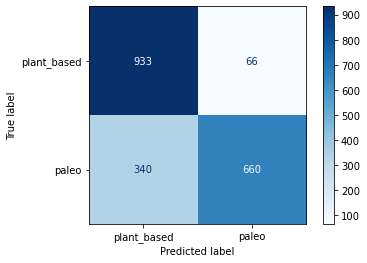

In [30]:
plot_confusion_matrix(xgb_rs, X_test, y_test, cmap='Blues', values_format='d', display_labels=['plant_based',  'paleo']);

In [31]:
# Accuracy
accuracy_score(y_test, y_pred)

0.7968984492246123

In [32]:
# Specificity - Optimize TN (909), No FP (90)
tn / (tn + fp)

0.933933933933934

In [33]:
# Sensitivity (Recall) - Optimizing for TP (687), No FN (313)
recall_score(y_test, y_pred)

0.66

**With plant-based being negative (0) and paleo being positive (1), the model seemed to favor the plant-based diet. Of the 2,000 submissions used to test:**

* 933 were true negatives (guessed plant-based, truly plant-based)
* 660 were true positives (guessed paleo, truly paleo)
* 340 were false negatives (guessed plant-based, actually paleo)
* 66 were false positives (guessed paleo, actually plant-based)

**This means that the model is optimizing for true negatives with a 93% accuracy, while the accuracy for true positives is 66%. Therefore, this model is better at predicting plant-based submissions.**

---

## Conclusion: Recommendations and Next Steps

It’s recommended to keep the XGBoost classification model in mind as a best-performer, as it showed the most promising results despite the imbalance in accuracy between the diets.

With the plant-based and paleo datasets, it will be beneficial to identify the words that could be causing the paleo submissions to be mistaken for plant-based submissions. Removing words relating to the diets’ commonalities, such as fruits and vegetables, may result in model improvement. It will also be beneficial to pull more submissions from each subreddit and run the model on larger datasets.

The XGBoost model should also be tried with other diet datasets, such as Mediterranean, Keto, Vegetarian, Gluten-Free, etc. to see how it performs there.